In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from orthogonal_dfa.spliceai.load_model import load_spliceai

from orthogonal_dfa.data.sample_text import sample_text
from orthogonal_dfa.deep_dfa import ProbabilisticAutoma
from orthogonal_dfa.math import corr
from orthogonal_dfa.manual_dfa.stop_codon_dfa import stop_codon_dfa

from orthogonal_dfa.oracle.evaluate import (
    multidimensional_confusion,
    print_metrics,
    pack_as_uint32,
    conditional_mutual_information,
    ConditionalMutualInformation,
    actual_pct_difference_by_prediction,
    evaluate_dfas,
    DEMO_SEED,
)
from orthogonal_dfa.spliceai.load_model import load_spliceai
from orthogonal_dfa.data.exon import default_exon
from orthogonal_dfa.utils.dfa import (
    dfa_symbols_to_num,
    TorchDFA,
    p_to_al,
    dfa_symbols_to_acgt,
)
from orthogonal_dfa.mutation.mutation import RandomSingleMutation

from orthogonal_dfa.algorithms.greedy import greedy_optimize
from orthogonal_dfa.experiments.sensitivity import *

In [5]:
no_orf = stop_codon_dfa()

In [6]:
no_orf_ta = stop_codon_dfa(("TAG", "TAA"))

In [7]:
settings = {
    "no-ORF": (no_orf,),
    "no-ORF-TA": (no_orf_ta,),
    "no-ORF | no-ORF-TA": (no_orf, no_orf_ta),
}

In [8]:
rsm = RandomSingleMutation()

In [9]:
len(no_orf.states), len(no_orf_ta.states)

(20, 16)

In [10]:
num_self_loops_each = {
    x: sum(y == x for y in v.values()) for x, v in no_orf.transition_function.items()
}
num_self_loops_each = {k: v for k, v in num_self_loops_each.items() if v}
print(
    f"Num self loops by state: {num_self_loops_each}; total: {sum(num_self_loops_each.values())}"
)

Num self loops by state: {19: 4, 0: 3, 1: 1}; total: 8


In [11]:
model = load_spliceai(400, 0)

In [12]:
def eval_de(d, *c):
    return evaluate_dfas(default_exon, [d], c, model, count=100_000, seed=DEMO_SEED)[0]

In [13]:
for k, s in settings.items():
    print(k)
    print()
    print_metrics(eval_de(*s))
    print()

no-ORF

Mutual Information:
    0.0471b (0.0450b, 0.0493b)
Actual % Difference by Prediction:
    -35.41% (-36.15%, -34.67%)

no-ORF-TA

Mutual Information:
    0.0630b (0.0605b, 0.0656b)
Actual % Difference by Prediction:
    -30.43% (-31.02%, -29.82%)

no-ORF | no-ORF-TA

Mutual Information:
    0.0098b (0.0088b, 0.0109b)
Actual % Difference by Prediction:
    28.81% (28.45%, 29.17%)



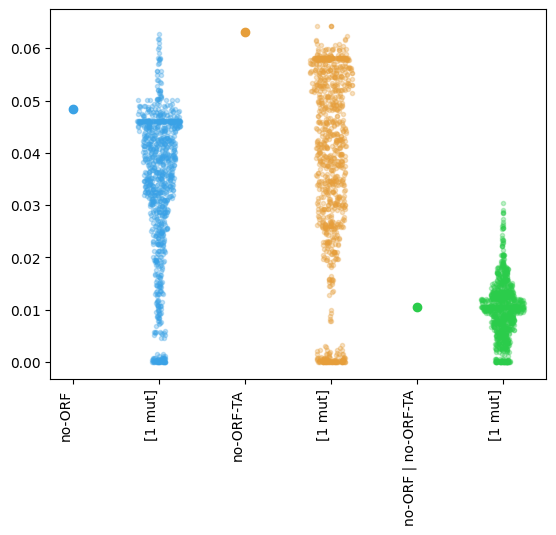

In [14]:
plot_sensitivity(settings, model, default_exon, 1000, 0, ConditionalMutualInformation())

In [15]:
optimal, path = greedy_optimize(
    no_orf_ta,
    default_exon,
    model,
    rsm,
    seed=0,
    scoring=ConditionalMutualInformation(),
    tolerance=0.01,
)

In [16]:
path

[(array([1, 7, 1, 1], dtype=uint32), 0.06856502157193993)]

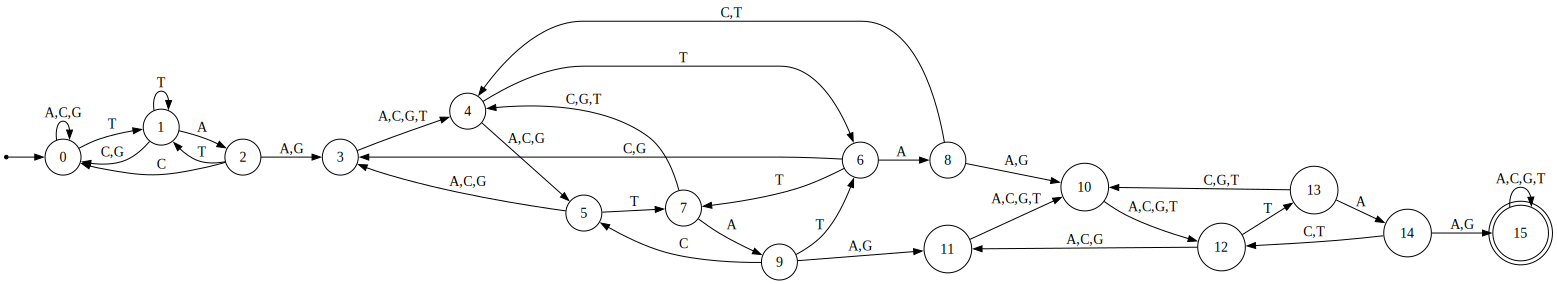

In [17]:
p_to_al(no_orf_ta)